In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from helpers import imshow

In [2]:
# ORB Functions
""" Clear matches for which NN ratio is > than threshold """
def filter_distance(matches,ratio):
    dist = [m.distance for m in matches]
    thres_dist = (sum(dist) / len(dist)) * ratio

    # keep only the reasonable matches
    sel_matches = [m for m in matches if m.distance < thres_dist]
    #print '#selected matches:%d (out of %d)' % (len(sel_matches), len(matches))
    return sel_matches

""" keep only symmetric matches """
def filter_asymmetric(matches, matches2):
    sel_matches = []
    for match1 in matches:
        for match2 in matches2:
            if k_ftr[match1.queryIdx] == k_ftr[match2.trainIdx] and k_scene[match1.trainIdx] == k_scene[match2.queryIdx]:
                sel_matches.append(match1)
                break
    return sel_matches

# Todo: filter_ransac

def filter_matches(matches, matches2):
    matches = filter_distance(matches)
    matches2 = filter_distance(matches2)
    return filter_asymmetric(matches, matches2)

def recArea(dst):
    qp = dst
    #tl = qp[0][0] #top left
    #bl = qp[0][1] #botton left
    #br = qp[0][2] #botton right
    #tr = qp[0][3] #top right
    qp = qp[0] #qp stores all the points
    area = 0
    j = 3
    for i in range(4):
        area = area + (qp[j][0]+qp[i][0])*(qp[j][1]-qp[i][1])
        j = i
    return area/2

def orbTrack(trainImg,trainKP,trainDesc,QueryImgBGR,h,w):
    MIN_MATCH_COUNT=15

    detector=cv2.ORB_create()

    #FLANN_INDEX_KDITREE=0
    #flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    #searchParam = dict(checks=50)
    #flann=cv2.FlannBasedMatcher(flannParam,searchParam)
    #flann=cv2.FlannBasedMatcher(flannParam,{})
    
    QueryImg=cv2.cvtColor(QueryImgBGR,cv2.COLOR_BGR2GRAY)
    queryKP,queryDesc=detector.detectAndCompute(QueryImg,None)
    #matches=flann.knnMatch(queryDesc,trainDesc,k=2)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    #matches = bf.knnMatch(queryDesc,trainDesc)
    goodMatchA = bf.match(queryDesc,trainDesc)
    #goodMatchB = bf.match(trainDesc,queryDesc)
    goodMatch = filter_distance(goodMatchA,ratio=0.65)
    #goodMatchB = filter_distance(goodMatchB,ratio=0.65)
    #filter distance
    
    # Sort them in the order of their distance.
    # matches = sorted(matches, key = lambda x:x.distance)
    queryBorder = None
    qp = None
    #print(goodMatch[0]) 
    
    #goodMatch = filter_matches(goodMatchA,goodMatchB)
    #print(len(goodMatch)) 
    if(len(goodMatch) > MIN_MATCH_COUNT):
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        
        #h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        return (1,queryBorder,qp)
        #print(queryBorder)
    else:
        #print("Not Enough match found")
        return (-1,queryBorder,qp)
    
def findOrientation(dst):
    qp = dst
    tl = qp[0][0] #top left
    bl = qp[0][1] #botton left
    br = qp[0][2] #botton right
    tr = qp[0][3] #top right
    center = [(tl[0]+br[0])/2,(tl[1]+br[1])/2]
    x1 = bl[0]
    x2 = br[0]
    y1 = bl[1]
    y2 = br[1]
    if y1 >= y2:
        l = x2 - x1 
        h = y1 - y2
        theta = np.arctan(l/h)/np.pi*360
    else:
        l = x2 - x1
        h = y2 - y1
        theta = 360-(np.arctan(l/h)/np.pi*360)
    
    if theta < 180:
        theta = 90-(theta/2)
    else:
        theta = 450 - (theta/2)
    
    #center is the center of the detected object
    #theta is the angle of it
    return center,theta

In [3]:
def whiteOut(frame):
    #remove white stuff, return a mask of the intsresting stuff
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of white color in HSV
    # change it according to your need !
    sensitivity = 14
    #lower_white = np.array([0,0,255-sensitivity])
    #upper_white = np.array([255,sensitivity,255])
    
    lower_white = np.array([0, 0, 255-sensitivity])
    upper_white = np.array([180, sensitivity, 255])
    
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel,iterations = iteration_open)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel,iterations = iteration_open)    
    
    return mask,np.abs(255-res)
    #1 - res is what we want, np.multiply(frame,1-res) gives what we want

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    diag = max(nW,nH)
 
    # perform the actual rotation and return the image
    #return [nW,nH],cv2.warpAffine(image, M, (nW, nH),borderValue = (255,255,255))
    return diag,cv2.warpAffine(image, M, (diag, diag),borderValue = (255,255,255))

def OverLay(background,image,center,theta,scale):
    #first let's recize the image
    h,w,d = image.shape
    h = int(np.floor(h*scale))
    w = int(np.floor(w*scale))   
    resized  = cv2.resize(image, (w,h))
    
    #rows,cols,d = resized.shape
    #M = cv2.getRotationMatrix2D((np.floor(cols/2),np.floor(rows/2)),theta,1)
    
    #this line needs to be changed for better performance
    #diag = int(np.floor(np.sqrt(rows*rows+cols*cols)))
    #diag = int(np.maximum(rows,cols))
    #dst = cv2.warpAffine(resized,M,(diag,diag),borderValue = (255,255,255))
    
    diag, dst = rotate_bound(resized, theta)
    #diag = int(np.floor(np.sqrt(nW*nW+nH*nH)))
       
    #h,w,d = dst.shape
    mask,res = whiteOut(dst)
    imshow(res)
    
    x_center = center[0]
    y_center = center[1]
    
    result = background.copy()
    cols,rows,d = result.shape
    
    tx = np.floor(x_center - diag/2)
    #xcenter
    ty = np.floor(y_center - diag/2)
    #ycenter
    
    
    Ry0 = int(ty)
    Ry1 = int(ty+diag)
    #Ry1 = int(ty+nH)
    Rx0 = int(tx)
    Rx1 = int(tx+diag)
    #Rx1 = int(tx+nW)
    Fy0 = int(0)
    Fy1 = int(0+diag)
    #Fy1 = int(0+nH)
    Fx0 = int(0)
    Fx1 = int(0+diag)
    #Fx1 = int(0+nW)
    
    
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    
    '''
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    '''
            
    newImg = result[Ry0:Ry1,Rx0:Rx1,:]
    dst = dst[Fy0:Fy1,Fx0:Fx1,:]
    res = res[Fy0:Fy1,Fx0:Fx1,:]
    imshow(newImg)
    imshow(dst)
    res2 = np.abs(255-res)
    img2 = cv2.bitwise_and(dst,res)
    img3 = cv2.bitwise_and(newImg,res2)
    final = np.add(img2,img3)
    result[Ry0:Ry1,Rx0:Rx1] = final
    
    return result

In [4]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 200
params.filterByCircularity = True
params.minCircularity = 0.5
params.filterByConvexity = False
params.minConvexity = 0.7
detector = cv2.SimpleBlobDetector_create(params)

def segment_skin_ycrcb(img):
    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)    
    
    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([255,173,127],np.uint8)

    # Find region with skin tone in YCrCb image
    mask = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 3)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

hi
hi
hi
hi
hi
hi
hi
hi
hi


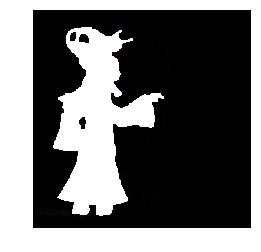

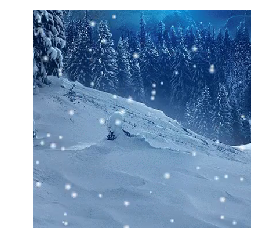

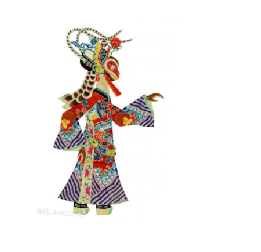

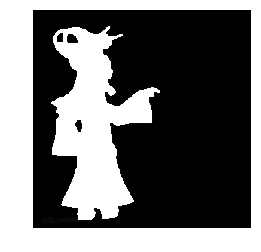

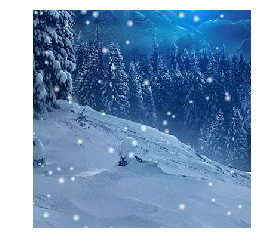

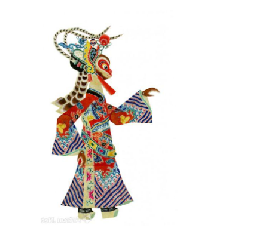

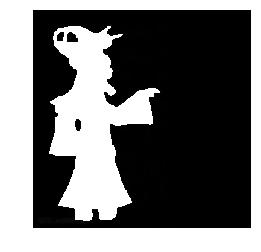

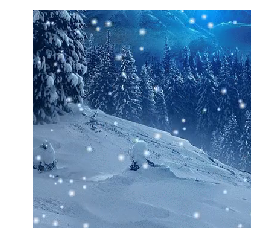

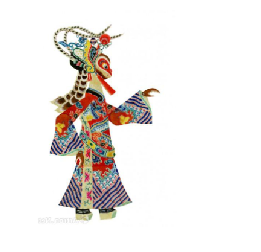

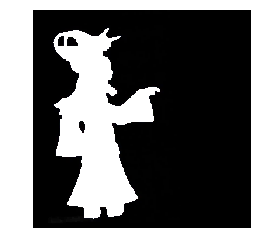

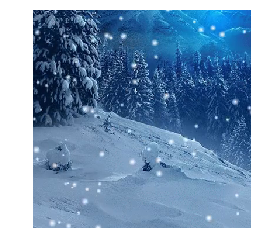

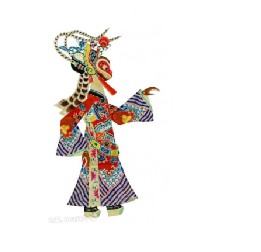

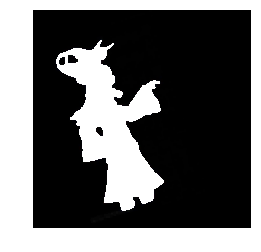

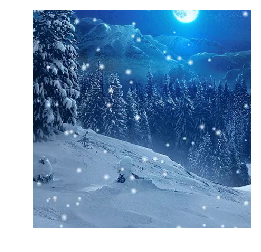

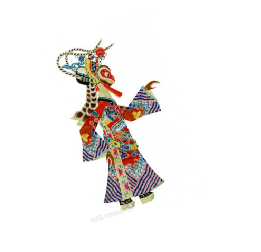

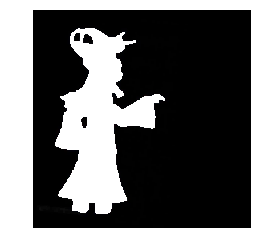

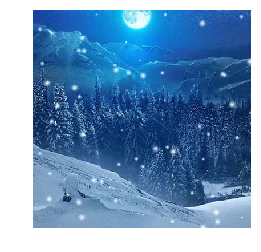

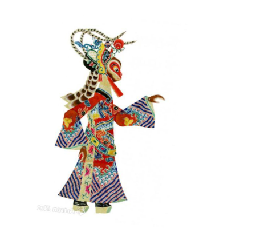

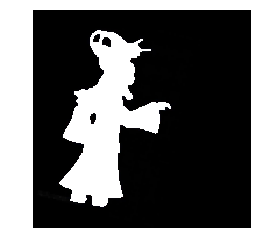

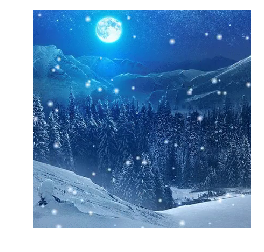

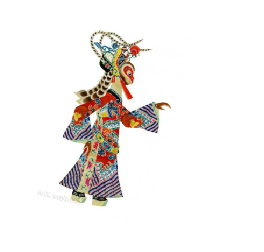

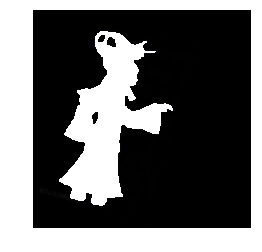

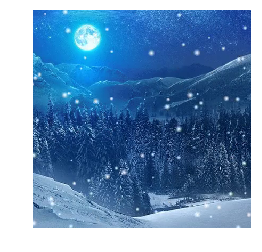

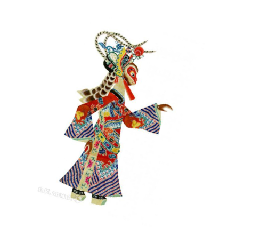

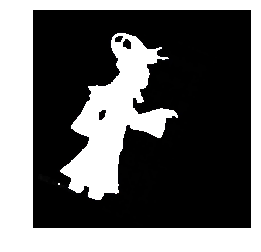

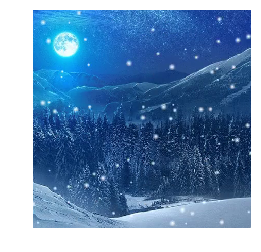

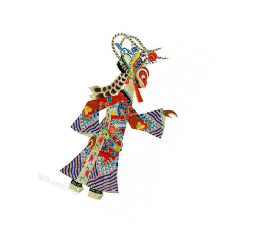

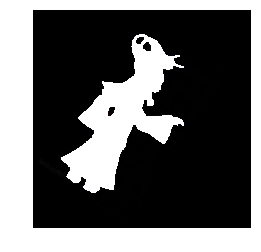

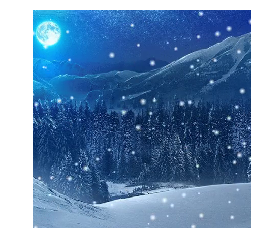

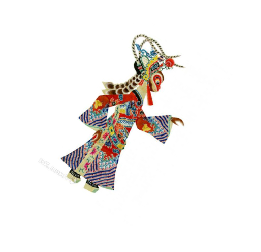

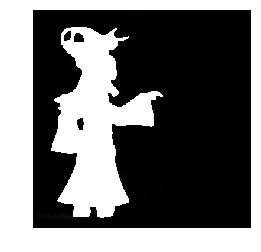

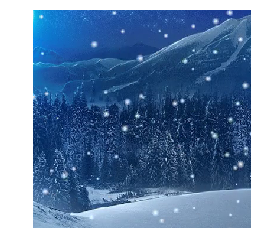

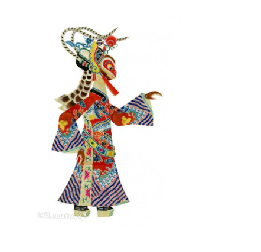

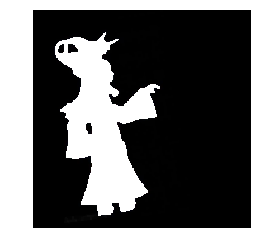

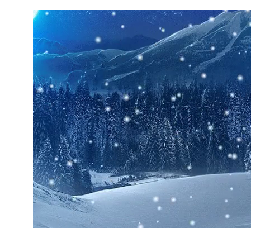

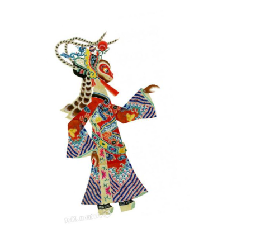

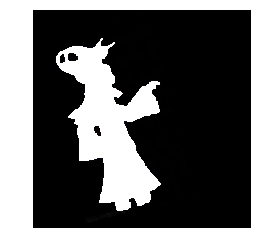

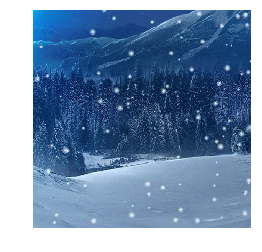

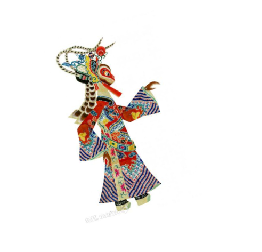

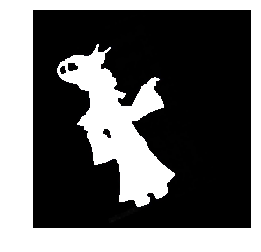

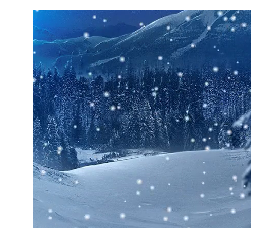

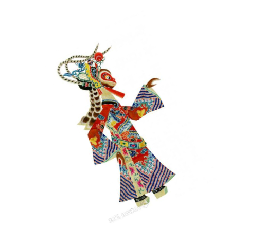

hi


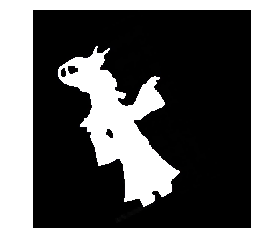

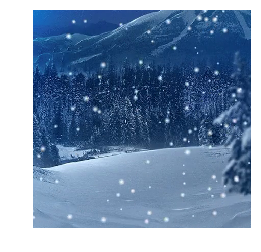

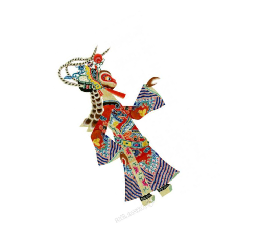

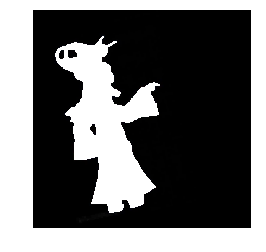

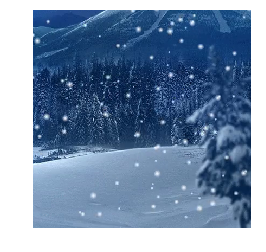

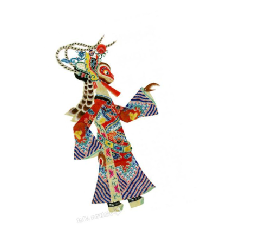

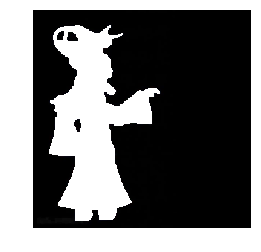

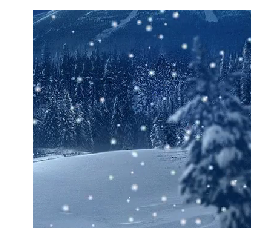

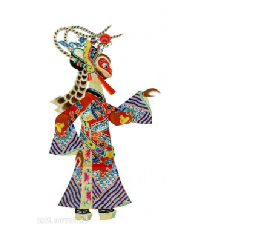

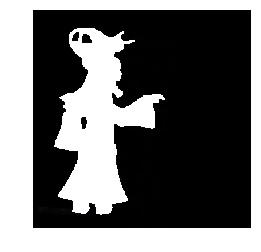

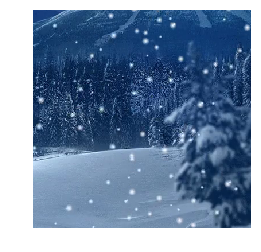

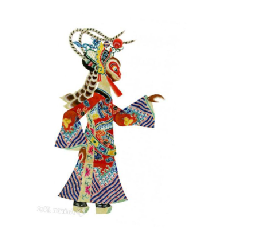

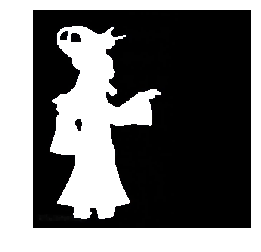

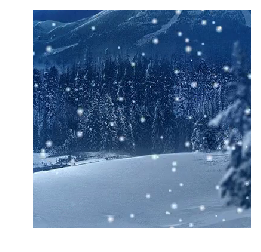

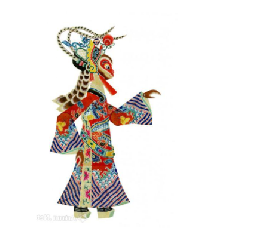

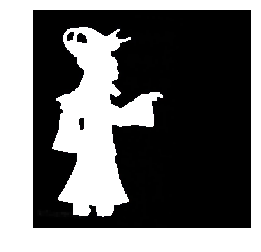

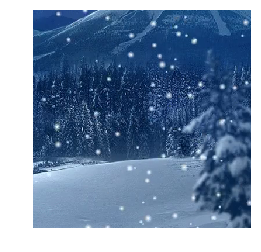

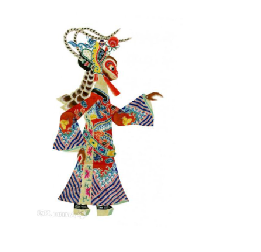

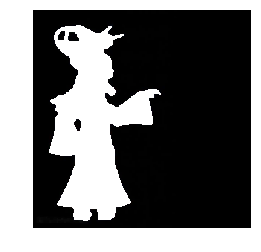

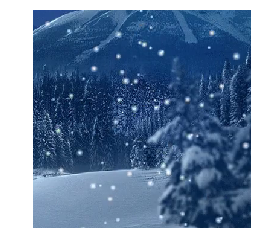

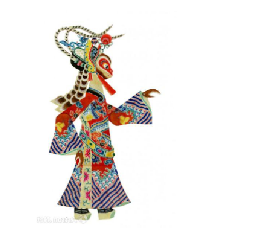

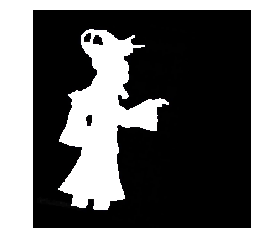

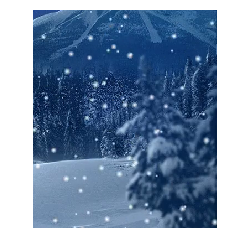

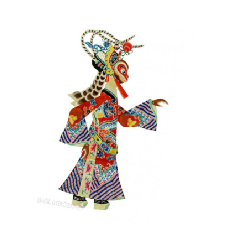

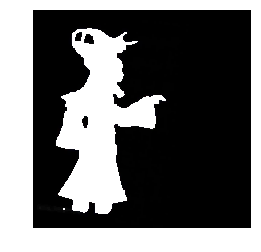

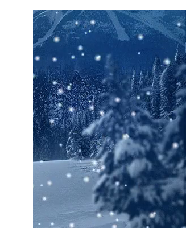

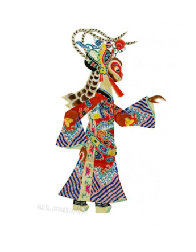

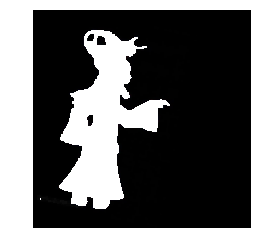

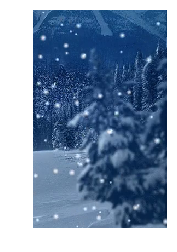

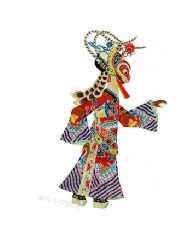

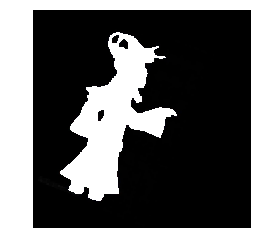

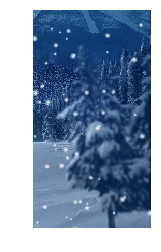

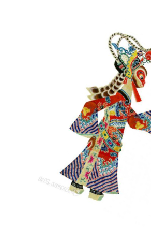

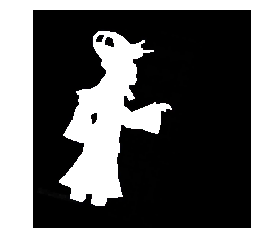

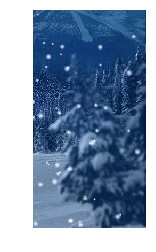

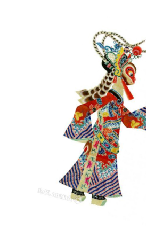

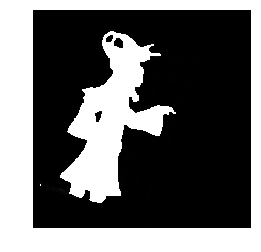

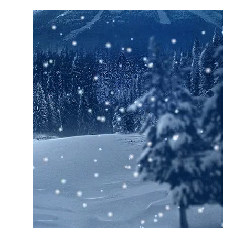

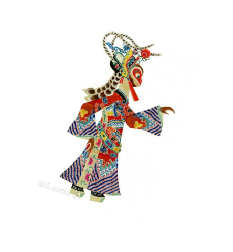

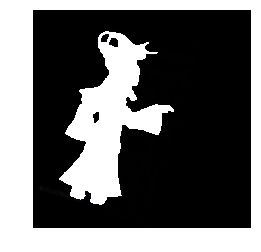

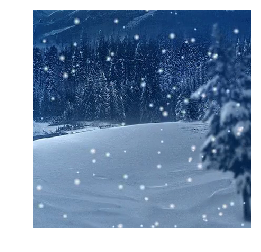

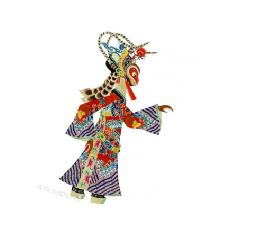

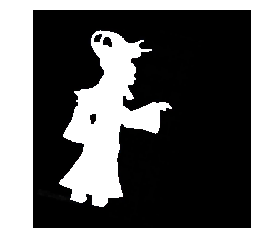

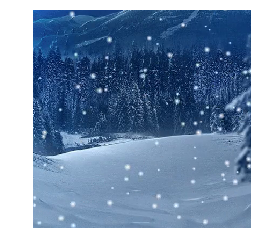

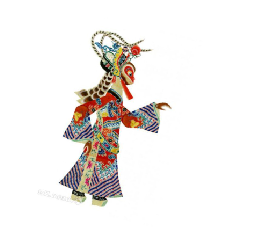

hi


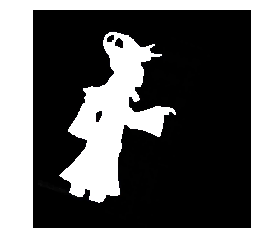

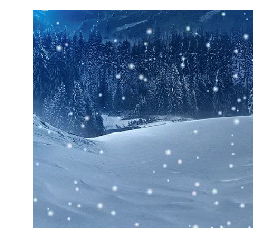

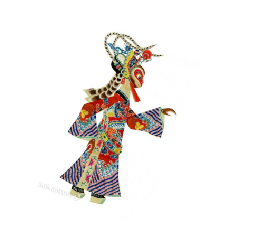

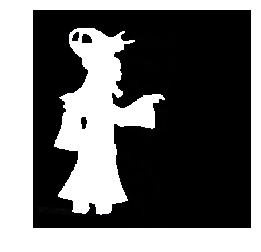

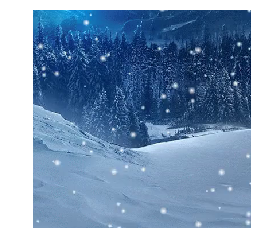

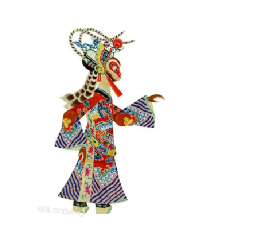

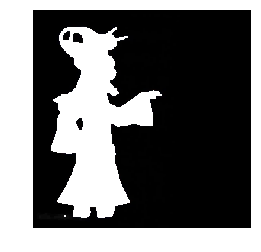

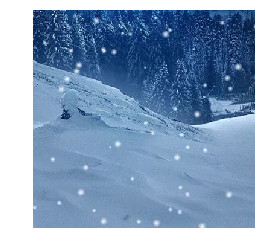

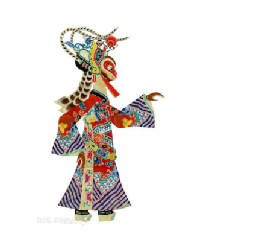

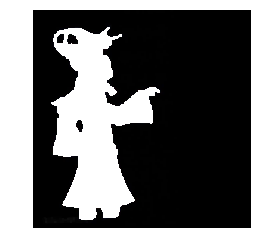

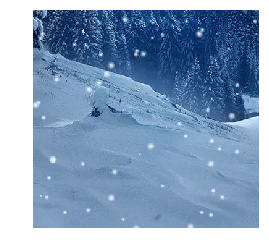

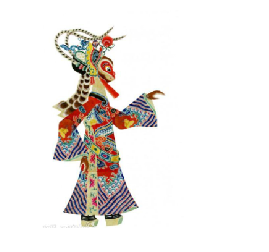

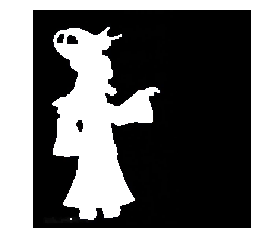

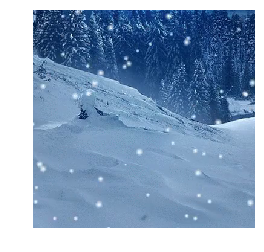

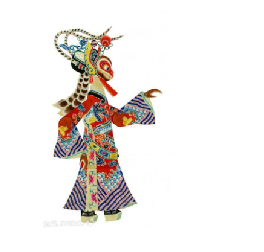

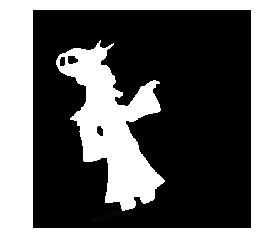

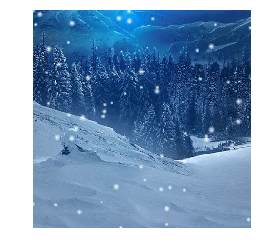

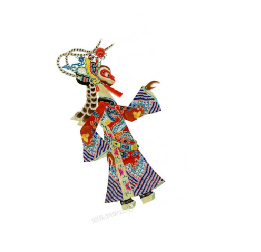

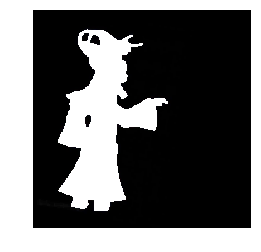

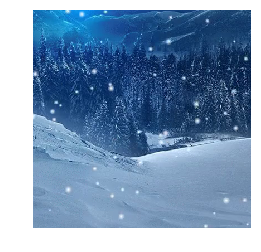

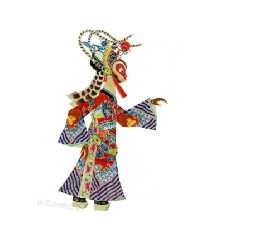

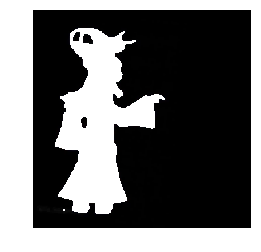

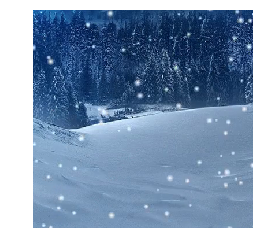

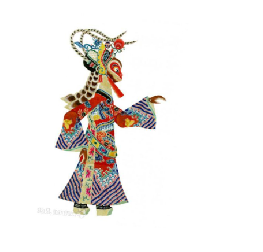

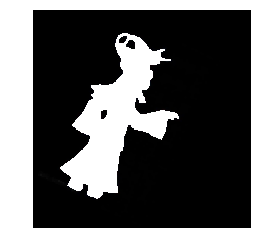

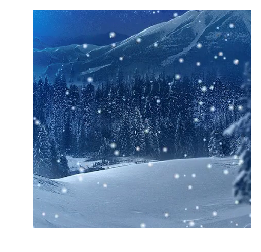

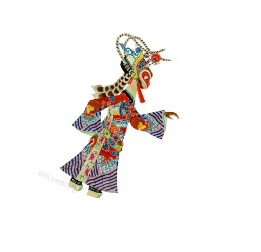

hi
hi
hi
hi


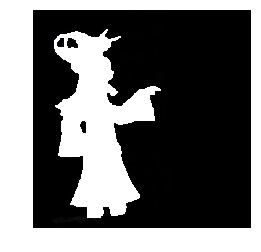

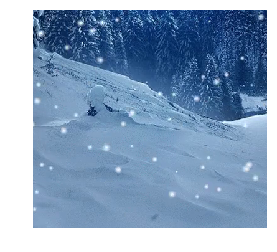

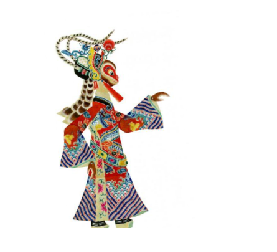

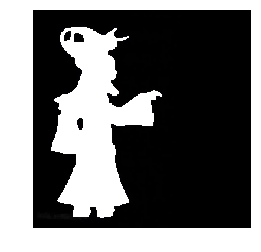

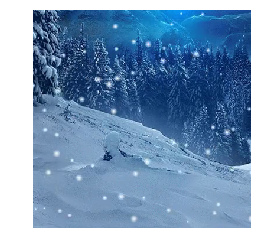

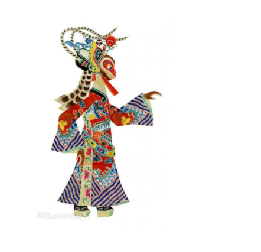

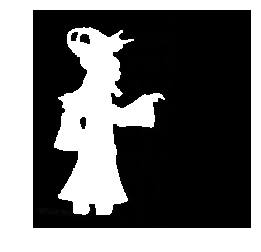

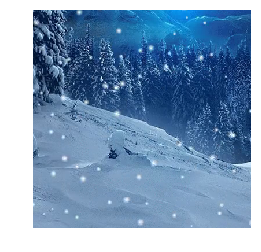

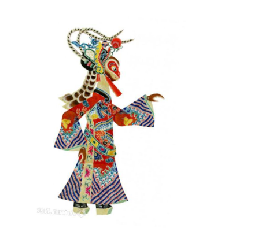

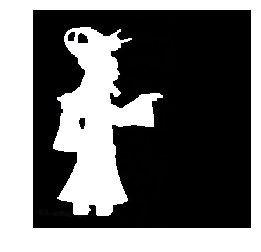

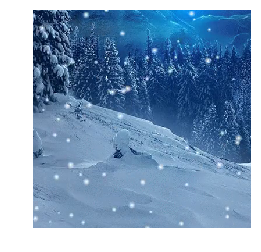

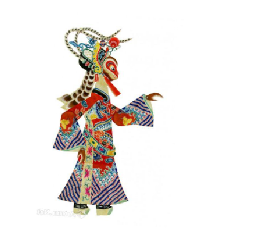

hi
hi
hi
hi
hi
hi
hi
hi


In [8]:
cam = cv2.VideoCapture(0)
img1 = cv2.imread("demo.jpg")
snow_video = cv2.VideoCapture('snow.mp4')
_, background = snow_video.read()#cv2.imread("bk.png")
img1 = cv2.flip(img1,1)
h,w,d = img1.shape
detector = cv2.ORB_create()
kp1, des1 = detector.detectAndCompute(img1,None)
snow_frame_counter = 0
while True:
    ret_snow, background = snow_video.read()
    snow_frame_counter += 1
    if snow_frame_counter == snow_video.get(cv2.CAP_PROP_FRAME_COUNT) - 1:
        print('hi')
        snow_frame_counter = 0
        snow_video = cv2.VideoCapture('snow.mp4')
    
    ret, img2 = cam.read()
    img2 = cv2.flip(img2,1)
    checker,dst,_ = orbTrack(img1,kp1,des1,img2,h,w)
    #checker2,dst2,qp2 = orbTrack(img1,kp1,des1,img2,h,w)
#     img2_for_pinch = cv2.medianBlur(img2,9)
#     mask_for_pinch = segment_skin_ycrcb(img2_for_pinch)
#     cv2.imshow('mask',mask_for_pinch)
#     keypoints = detector.detect(mask_for_pinch)
    result = background.copy()
#     for k in keypoints:
#         print('Pinch Detected')
    #mask = img2.copy()
    if checker != -1:
        #center = findOrientation(qp)
        #mask = cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5)
        center,theta = findOrientation(dst)
        area = recArea(dst)
        result = OverLay(background,img1,[int(center[0]),int(center[1])],theta,0.6)
        #cv2.putText(mask, str(area), (int(np.floor(center[0])),int(np.floor(center[1]))), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 255, 255), 2)
        #cv2.circle(mask,(int(np.floor(center[0])),int(np.floor(center[1]))), 3, (0,0,255), -1)
        #cv2.circle(mask,(np.floor(dst[0][1][0]),np.floor(dst[0][1][1])), 3, (0,0,255), -1)
        #cv2.circle(mask,(qp[0][0][0],qp[0][0][q]), 63, (0,0,255), -1)
        #mask = cv2.polylines(mask,[np.int32(dst2)],True,(0,255,0),5)
        #print("YES")
    
    keypressed = cv2.waitKey(5)
    if keypressed == 27:
        break
    cv2.imshow('mask',result)
    
cam.release()
cv2.destroyAllWindows()